## Library

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm
from skimage.transform import resize
import cv2
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

## Init GPU

In [2]:
# Initialize GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

print(device)

GPU: Tesla T4 is available.

cuda


In [3]:
%load_ext autoreload
%autoreload 2

## Config Info

In [4]:
# Constants
TEST_SIZE = 0.2
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2
TEST_BATCH_SIZE = 2
MAX_SLICES = 60
NUM_EPOCHS = 20
ACCUMULATION_STEPS = 64
LEARNING_RATE = 0.0005
ROC_CURVE = '/kaggle/working/roc_curve.png'
SHAPE = (HEIGHT, WIDTH, CHANNELS)

In [5]:
# Kaggle and local switch
import os
# Set paths based on environment
KAGGLE = os.path.exists('/kaggle')
print("Running on Kaggle" if KAGGLE else "Running locally")

DATA_DIR = '/kaggle/input/rsna-mil-training/' if KAGGLE else '../rsna-mil-training/'
DICOM_DIR = DATA_DIR + 'rsna-mil-training'
CSV_PATH = DATA_DIR + 'training_1000_scan_subset.csv' if KAGGLE else './data_analyze/training_1000_scan_subset.csv'

# Load patient scan labels
patient_scan_labels = pd.read_csv(CSV_PATH)

Running on Kaggle


## Data Preprocessing

In [6]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
   
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    
    bsb_img = np.stack([brain_img, subdural_img, soft_img], axis=-1)
    return bsb_img.astype(np.float16)

In [7]:
def preprocess_slice(slice, target_size=(HEIGHT, WIDTH)):
    # Check if type of slice is dicom 
    if (type(slice) == np.ndarray):
        slice = resize(slice, target_size, anti_aliasing=True)
        brain_window = apply_windowing(slice, window=(40, 80))
        subdural_window = apply_windowing(slice, window=(80, 200))
        bone_window = apply_windowing(slice, window=(600, 2800))
        
        multichannel_slice = np.stack([brain_window, subdural_window, bone_window], axis=-1)
        return multichannel_slice.astype(np.float16)
    else:
        slice = bsb_window(slice)
        return slice.astype(np.float16)

def apply_windowing(slice, window):
    window_width, window_level = window
    lower_bound = window_level - window_width // 2
    upper_bound = window_level + window_width // 2
    
    windowed_slice = np.clip(slice, lower_bound, upper_bound)
    windowed_slice = (windowed_slice - lower_bound) / (upper_bound - lower_bound)
    return windowed_slice

In [8]:
def read_dicom_folder(folder_path):
    slices = []
    for filename in sorted(os.listdir(folder_path))[:MAX_SLICES]:  # Limit to MAX_SLICES
        if filename.endswith(".dcm"):
            file_path = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(file_path)
            slices.append(ds)
    
    # Pad with black images if necessary
    while len(slices) < MAX_SLICES:
        slices.append(np.zeros_like(slices[0].pixel_array))
    
    return slices[:MAX_SLICES]  # Ensure we return exactly MAX_SLICES

## Data augmentation

In [9]:
import numpy as np
from scipy.ndimage import rotate

def augment_image(image):
    # Ensure the image is a copy to avoid negative strides
    image = np.copy(image)
    
    # Convert the image to float32 to ensure compatibility with scipy's rotate function
    image = image.astype(np.float32)
    
    # Flip the image horizontally with 50% probability
    if np.random.rand() < 0.5:
        image = np.flip(image, axis=1)
    
    # Flip the image vertically with 50% probability
    if np.random.rand() < 0.5:
        image = np.flip(image, axis=0)  # Use axis=0 for vertical flip
    
    # Rotate the image by a random angle between -15 and 15 degrees with 50% probability
    if np.random.rand() < 0.5:
        angle = np.random.uniform(-15, 15)
        image = rotate(image, angle, axes=(1, 2), reshape=False, mode='nearest')
    
    return image

## Split Dataset

In [10]:
def split_dataset(patient_scan_labels, test_size=0.2, val_size=0.2, random_state=42):
    """
    Split the dataset into training, validation, and testing sets while maintaining the same ratio of labels.

    Args:
        patient_scan_labels (pd.DataFrame): The DataFrame containing patient scan labels.
        test_size (float): The proportion of the dataset to include in the test split.
        val_size (float): The proportion of the training set to include in the validation split.
        random_state (int): The seed used by the random number generator.

    Returns:
        Tuple: train_labels, val_labels, test_labels
    """
    # If any of the hemorrhage indicators is 1, the label is 1, otherwise 0
    patient_scan_labels['label'] = patient_scan_labels[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any(axis=1).astype(int)

    # Extract the labels from the DataFrame
    labels = patient_scan_labels['label']

    # First, split off the test set
    train_val_labels, test_labels = train_test_split(
        patient_scan_labels, 
        test_size=test_size, 
        stratify=labels, 
        random_state=random_state
    )

    # Calculate the validation size relative to the train_val set
    val_size_adjusted = val_size / (1 - test_size)

    # Split the train_val set into train and validation sets
    train_labels, val_labels = train_test_split(
        train_val_labels, 
        test_size=val_size_adjusted, 
        stratify=train_val_labels['label'], 
        random_state=random_state
    )

    return train_labels, val_labels, test_labels

In [11]:
def process_patient_data(dicom_dir, row):
    patient_id = row['patient_id'].replace('ID_', '')
    study_instance_uid = row['study_instance_uid'].replace('ID_', '')
    
    folder_name = f"{patient_id}_{study_instance_uid}"
    folder_path = os.path.join(dicom_dir, folder_name)
    
    if os.path.exists(folder_path):
        slices = read_dicom_folder(folder_path)
        preprocessed_slices = [preprocess_slice(slice) for slice in slices]
        
        # Thêm chiều depth
        preprocessed_slices = np.stack(preprocessed_slices, axis=0)  # (depth, height, width, channels)
        preprocessed_slices = np.transpose(preprocessed_slices, (3, 0, 1, 2))  # (channels, depth, height, width)
        
        label = 1 if row[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any() else 0
        
        return preprocessed_slices, label
    else:
        print(f"Folder not found: {folder_path}")
        return None, None

In [12]:
class TrainDatasetGenerator(Dataset):
    """
    A custom dataset class for training data.
    """
    def __init__(self, data_dir, patient_scan_labels, augment=True):
        self.data_dir = data_dir
        self.patient_scan_labels = patient_scan_labels
        self.augment = augment

    def __len__(self):
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        row = self.patient_scan_labels.iloc[idx]
        preprocessed_slices, label = process_patient_data(self.data_dir, row)
        
        if preprocessed_slices is not None:
            # Convert the list of numpy arrays to a single numpy array
            preprocessed_slices = np.array(preprocessed_slices)  # Convert to numpy array
            if self.augment:
                preprocessed_slices = augment_image(preprocessed_slices)
                
            # Make a contiguous copy of the array to ensure positive strides to fix 
            # ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 
            preprocessed_slices = np.ascontiguousarray(preprocessed_slices)
            
            return torch.tensor(preprocessed_slices, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        else:
            return None, None  # Handle the case where the folder is not found

class TestDatasetGenerator(Dataset):
    """
    A custom dataset class for testing data.
    """
    def __init__(self, data_dir, patient_scan_labels, augment=True):
        self.data_dir = data_dir
        self.patient_scan_labels = patient_scan_labels
        self.augment = augment

    def __len__(self):
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        row = self.patient_scan_labels.iloc[idx]
        preprocessed_slices, label = process_patient_data(self.data_dir, row)
        
        if preprocessed_slices is not None:
            # Convert the list of numpy arrays to a single numpy array
            preprocessed_slices = np.array(preprocessed_slices)  # Convert to numpy array
            if self.augment:
                preprocessed_slices = augment_image(preprocessed_slices)
            
            preprocessed_slices = np.ascontiguousarray(preprocessed_slices)

            return torch.tensor(preprocessed_slices, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        else:
            return None, None  # Handle the case where the folder is not found

In [13]:
def get_train_loader(dicom_dir, patient_scan_labels, batch_size=TRAIN_BATCH_SIZE, shuffle=True):
    train_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels)
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

def get_test_loader(dicom_dir, patient_scan_labels, batch_size=TEST_BATCH_SIZE):
    test_dataset = TestDatasetGenerator(dicom_dir, patient_scan_labels)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

## CNN Feature Extractor

In [14]:
class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [15]:
class ResNet3D_MIL(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet3D_MIL, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv3d(3, 64, kernel_size=7, stride=(1, 2, 2), padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.5)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (batch_size, num_instances, channels, depth, height, width)
        batch_size, c, d, h, w = x.size()
        x = x.view(batch_size, c, d, h, w)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.dropout(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)

        # Reshape back to (batch_size, num_instances, num_classes)
        # out = out.view(batch_size, num_instances, -1)

        # MIL aggregation (max pooling over instances)
        out = torch.max(out, dim=1)[0]

        return out

def ResNet3D18_MIL():
    return ResNet3D_MIL(ResidualBlock3D, [2, 2, 2, 2])

In [16]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=LEARNING_RATE, device='cuda'):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
    scaler = GradScaler()
    
    best_val_accuracy = 0.0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_labels = []

        for i, (batch_data, batch_labels) in enumerate(train_loader):
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.float().to(device)

            with autocast(device_type=device):
                outputs = model(batch_data).squeeze()
                loss = criterion(outputs, batch_labels)
                loss = loss / ACCUMULATION_STEPS

            scaler.scale(loss).backward()

            if (i + 1) % ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            train_loss += loss.item() * ACCUMULATION_STEPS
            train_predictions.extend((outputs > 0).cpu().numpy())
            train_labels.extend(batch_labels.cpu().numpy())

        train_accuracy = accuracy_score(train_labels, train_predictions)
        train_precision = precision_score(train_labels, train_predictions)
        train_recall = recall_score(train_labels, train_predictions)
        train_f1 = f1_score(train_labels, train_predictions)

        # Validation
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data = batch_data.to(device)
                batch_labels = batch_labels.float().to(device)

                with autocast(device_type=device):
                    outputs = model(batch_data).squeeze()
                    loss = criterion(outputs, batch_labels)

                val_loss += loss.item()
                val_predictions.extend((outputs > 0).cpu().numpy())
                val_labels.extend(batch_labels.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_predictions)
        val_precision = precision_score(val_labels, val_predictions, zero_division=1)
        val_recall = recall_score(val_labels, val_predictions)
        val_f1 = f1_score(val_labels, val_predictions)

        scheduler.step(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()

    # Load best model
    model.load_state_dict(best_model)
    return model

In [17]:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Sử dụng hàm train_model
    model = ResNet3D18_MIL()
    
    train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=TEST_SIZE)
    
    dicom_dir = DICOM_DIR if KAGGLE else DATA_DIR
        
    train_loader = get_train_loader(dicom_dir, train_labels, batch_size=8)
    val_loader = get_train_loader(dicom_dir, val_labels, batch_size=4)
    test_loader = get_test_loader(dicom_dir, test_labels, batch_size=4)
    
    trained_model = train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)

Epoch 1/5

Train Loss: 57.8353, Accuracy: 0.4900, Precision: 0.4319, Recall: 0.6640, F1: 0.5234

Val Loss: 230.2444, Accuracy: 0.5800, Precision: 1.0000, Recall: 0.0000, F1: 0.0000

Epoch 2/5

Train Loss: 81.0895, Accuracy: 0.5417, Precision: 0.4645, Recall: 0.5692, F1: 0.5115

Val Loss: 36.5283, Accuracy: 0.3950, Precision: 0.2967, Recall: 0.3214, F1: 0.3086

Epoch 3/5

Train Loss: 54.8010, Accuracy: 0.5083, Precision: 0.3918, Recall: 0.3004, F1: 0.3400

Val Loss: 37.2899, Accuracy: 0.5800, Precision: 1.0000, Recall: 0.0000, F1: 0.0000

Epoch 4/5

Train Loss: 50.5146, Accuracy: 0.6000, Precision: 0.6000, Recall: 0.1542, F1: 0.2453

Val Loss: 39.1614, Accuracy: 0.5800, Precision: 0.5000, Recall: 0.0119, F1: 0.0233

Epoch 5/5

Train Loss: 51.1569, Accuracy: 0.5833, Precision: 0.5079, Recall: 0.3794, F1: 0.4344

Val Loss: 35.7146, Accuracy: 0.5850, Precision: 0.5385, Recall: 0.0833, F1: 0.1443


## Test Model

In [18]:
def test_model(model, test_loader, device='cuda'):
    model = model.to(device)
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.float().to(device)

            outputs = model(batch_data).squeeze()
            test_predictions.extend((outputs > 0).cpu().numpy())
            test_labels.extend(batch_labels.cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_precision = precision_score(test_labels, test_predictions, zero_division=1)
    test_recall = recall_score(test_labels, test_predictions)
    test_f1 = f1_score(test_labels, test_predictions)

    print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

    return test_accuracy, test_precision, test_recall, test_f1

test_model(trained_model, test_loader)

Test Accuracy: 0.6200, Precision: 0.8333, Recall: 0.1190, F1: 0.2083


(0.62, 0.8333333333333334, 0.11904761904761904, 0.20833333333333331)

## Save Model

In [19]:
# Save the model
torch.save(trained_model.state_dict(), 'trained_model.pth')

In [20]:
# Load the model and test it on test loader and print the results of classification to a csv 

# Load the model
model = ResNet3D18_MIL()

# Load the trained model
model.load_state_dict(torch.load('trained_model.pth', weight_only=True))
model.eval()

dicom_dir = DICOM_DIR if KAGGLE else DATA_DIR

# Test the model
test_loader = get_test_loader(dicom_dir, test_labels, batch_size=4)
test_model(model, test_loader)

# Save the results to a csv file
results = []
with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.float().to(device)

        outputs = model(batch_data).squeeze()
        predictions = (outputs > 0).cpu().numpy()

        for i in range(len(predictions)):
            results.append({
                'prediction': predictions[i],
                'label': batch_labels[i].cpu().numpy()
            })
            
results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)

results_df.head()

/tmp/ipykernel_23/3424188302.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

  model.load_state_dict(torch.load('trained_model.pth'))


Test Accuracy: 0.6050, Precision: 0.6471, Recall: 0.1310, F1: 0.2178


,prediction,label
0,False,1.0
1,False,0.0
2,False,1.0
3,False,1.0
4,False,1.0


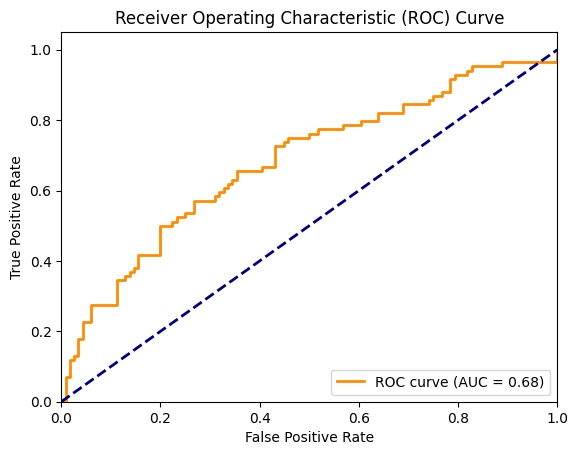

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, data_loader, device):
    model.eval()
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            outputs = model(batch_data).squeeze()
            all_scores.extend(outputs.cpu().numpy())
            all_labels.extend(batch_labels.numpy())
    
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(ROC_CURVE)
    plt.show()

# Sử dụng hàm này sau khi huấn luyện
plot_roc_curve(trained_model, test_loader, device)